In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [30]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, AgglomerativeClustering
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist

#Utility Function (Q1)

## Fundamental Cluster helper functions

In [82]:
def group_cluster(labels, data):             # Prepares dictionary of points to labels
  idx = np.arange(data.shape[0])
  clusters = dict()
  for label, id in zip(labels, idx):
    if label in clusters:
      clusters[label].append(id)
    else:
      clusters[label] = [id]
  return clusters

def process_cluster(clusters):               # Segregates the Single Clusters and Multi-Point Clusters
  single_point_clusters, multi_point_clusters = [], []
  for label, point_indices in clusters.items():
    if len(point_indices) == 1:
      single_point_clusters.append(point_indices[0])
    else:
      multi_point_clusters.append(tuple(point_indices))
  return single_point_clusters, multi_point_clusters

def summary(data, point_indices):
  return [len(point_indices), data[point_indices, :].sum(axis=0), np.square(data[point_indices, :]).sum(axis=0)]

def summarise_info_clusters(labels, data):    # Issues the Information corresponding to label-wise points
  compressed = []
  clusters = group_cluster(labels, data)
  for label, point_indices in clusters.items():
    summary_label = summary(data, point_indices)
    compressed.append({'N': summary_label[0],'SUM': summary_label[1],'SUMSQ': summary_label[2]})
  return compressed

def update_cluster(cluster, new_point=None, new_cluster=None):    # Update the cluster's info in terms of either point or cluster
  if new_point is not None and new_cluster is None:
    cluster['N'] += 1
    cluster['SUM'] += new_point
    cluster['SUMSQ'] += np.square(new_point)
    return cluster
  if new_cluster is not None and new_point is None:
    cluster['N'] += new_cluster['N']
    cluster['SUM'] += new_cluster['SUM']
    cluster['SUMSQ'] += new_cluster['SUMSQ']
    return cluster

## Fundamental helper functions

In [83]:
epsilon = 1e-10

def count_points(cluster_dicts):                                    # Count number of points from different cluster sets (DS & CS)
    return sum([clusters['N'] for clusters in cluster_dicts])

def calc_norm_mahalnobis(point, point_ref, std_ref):                # Returns Mahalnobis Distance 
  return np.sqrt(np.sum(np.square((point - point_ref) / (std_ref+epsilon))))

def calc_mahalnobis_cluster(cluster, point=None, cluster2=None):    # Calculate Mahalnobis Distance from reference cluster to either point or cluster 
  if point is not None and cluster2 is None:
    point_ref = cluster['SUM'] / cluster['N']
    std_ref = np.sqrt((cluster['SUMSQ'] / cluster['N']) - np.square(point_ref))
    return calc_norm_mahalnobis(point, point_ref, std_ref)
  if cluster2 is not None and point is None:
    c1 = cluster['SUM'] / cluster['N']
    c2 = cluster2['SUM'] / cluster2['N']
    std1 = np.sqrt((cluster['SUMSQ'] / cluster['N']) - np.square(c1))
    std2 = np.sqrt((cluster2['SUMSQ'] / cluster2['N']) - np.square(c2))
    return calc_norm_mahalnobis(c1, c2, std2 * std1)

def generate(ds_clusters, cs_clusters, rs_points):
  return {'DS Clusters': len(ds_clusters),
        'DS Points': count_points(ds_clusters),
        'CS Clusters': len(cs_clusters),
        'CS Points': count_points(cs_clusters),
        'RS Points': len(rs_points)}

def statistics(ds_clusters, cs_clusters, rs_points):
  stats = generate(ds_clusters, cs_clusters, rs_points)
  stats['SUM'] = stats['DS Points'] + stats['CS Points'] + stats['RS Points']
  print(stats)
  return stats

def predict(chunks, clusters, data, threshold):
  final_labels = []
  for chunk in range(chunks):
    for point_ind in range(len(data[chunk])):
      min_dist, assign_status = None, None
      for cluster_ind in range(len(clusters)):
        dist = calc_mahalnobis_cluster(clusters[cluster_ind], data[chunk][point_ind, 1:], None)
        if min_dist is None:
          min_dist, assign_status = dist, cluster_ind
          continue
        if dist < min_dist:
          min_dist, assign_status = dist, cluster_ind
      if min_dist < threshold:
        final_labels.append((int(data[chunk][point_ind, 0]), assign_status))
      else:
        final_labels.append((int(data[chunk][point_ind, 0]), -1))
  final_labels = sorted(final_labels, key=lambda x: x[0])
  return final_labels

def KM(data, num_clusters):
  df = data[:, 1:]
  kmeans = KMeans(n_clusters=num_clusters)
  label = kmeans.fit_predict(df)
  centroids = kmeans.cluster_centers_
  u_labels = np.unique(label)
  for i in u_labels:
    plt.scatter(df[label == i, 0], df[label == i, 1], label=i)
  plt.scatter(centroids[:, 0], centroids[:, 1], s=80, color='k')
  plt.legend()
  return kmeans

## Add-based helper functions

In [84]:
def add_points_to_clusters(points, clusters):
  features_dim = points.shape[1]
  threshold = 2 * np.sqrt(features_dim)
  unassigned_points = list()
  for point_ind in range(len(points)):
    min_dist, assign_status = None, None
    for cluster_ind in range(len(clusters)):
      dist = calc_mahalnobis_cluster(clusters[cluster_ind], points[point_ind], None)
      if min_dist is None:
        min_dist, assign_status = dist, cluster_ind
        continue
      if dist < min_dist:
        min_dist, assign_status = dist, cluster_ind       
    if min_dist < threshold:
      clusters[assign_status] = update_cluster(clusters[assign_status], points[point_ind], None)
    else:
      unassigned_points.append(point_ind)
  return unassigned_points

def merge_clusters(old_clusters, new_clusters, threshold, return_two):
  merge_tuples = list()
  for new_cluster_ind in range(len(new_clusters)):
    min_dist, assign_status = None, None
    for old_cluster_ind in range(len(old_clusters)):
      dist = calc_mahalnobis_cluster(old_clusters[old_cluster_ind], None, new_clusters[new_cluster_ind])
      if min_dist is None:
        min_dist, assign_status = dist, old_cluster_ind
        continue
      if dist < min_dist:
        min_dist, assign_status = dist, old_cluster_ind
    if min_dist < threshold:
      merge_tuples.append((assign_status, new_cluster_ind))
    else:
      continue
  for old_cluster_ind, new_cluster_ind in merge_tuples:
    old_cluster = old_clusters[old_cluster_ind]
    new_cluster = new_clusters[new_cluster_ind]
    old_clusters[old_cluster_ind] = update_cluster(old_cluster, None, new_cluster)
  for old_cluster_ind, new_cluster_ind in sorted(merge_tuples, key=lambda x: x[1], reverse=True):
    new_clusters.pop(new_cluster_ind)
  if return_two==True:
    return old_clusters, new_clusters
  else:
    old_clusters.extend(new_clusters)
    return old_clusters

#Main Program (Q1)

In [85]:
cs = pd.read_csv('/content/drive/MyDrive/MLBD_Assignment_1/train.csv')
arr = cs.to_numpy()
tr_label = arr[:,0]
num_clusters = 10

In [86]:
tr_features = PCA(n_components=2).fit_transform(arr[:,1:])
tr_data = np.hstack((tr_label.reshape((tr_label.shape[0],1)), tr_features))

In [87]:
np.random.shuffle(tr_data)

## For K1=100

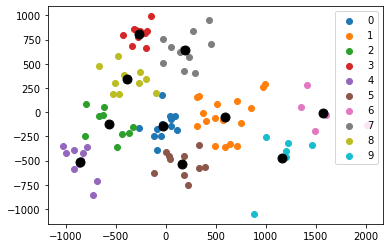

In [88]:
K = int(arr.shape[0]/100) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
threshold = 2 * np.sqrt(tr_splits[0].shape[1] - 1)
kmeans_1st_split = KM(tr_splits[0], num_clusters)

In [13]:
stats, cs_clusters, new_cs_clusters, rs_points = [], [], [], None
ds_clusters = summarise_info_clusters(kmeans_1st_split.labels_, tr_splits[0][:, 1:])
for chunk in range(1, K):
  unassigned_points = add_points_to_clusters(tr_splits[chunk][:, 1:], ds_clusters)
  if len(cs_clusters) > 0:
    if len(unassigned_points):
      unassigned_points = add_points_to_clusters(tr_splits[chunk][unassigned_points, 1:], cs_clusters)
  if len(unassigned_points) > 0:
    if chunk == 1:
      rs_points = tr_splits[chunk][unassigned_points, 1:]
    else:
      rs_points = np.append(rs_points, tr_splits[chunk][unassigned_points, 1:], axis=0)
  if len(rs_points) >= K:
    km = KMeans(K).fit(rs_points)
    rs_idx, cs_idx = process_cluster(group_cluster(km.labels_, rs_points))
    if len(cs_idx) > 0:
      if len(cs_clusters) > 0:
        new_cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      else:
        cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      if len(new_cs_clusters):
        cs_clusters = merge_clusters(cs_clusters, new_cs_clusters, threshold, return_two=False)
    if len(rs_idx) > 0:
      rs_points = rs_points[rs_idx]
  if chunk < (K - 1):
    stats.append(statistics(ds_clusters, cs_clusters, rs_points))

{'DS Clusters': 10, 'DS Points': 193, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 7, 'SUM': 200}
{'DS Clusters': 10, 'DS Points': 288, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 12, 'SUM': 300}
{'DS Clusters': 10, 'DS Points': 385, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 15, 'SUM': 400}
{'DS Clusters': 10, 'DS Points': 485, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 15, 'SUM': 500}
{'DS Clusters': 10, 'DS Points': 584, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 16, 'SUM': 600}
{'DS Clusters': 10, 'DS Points': 684, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 16, 'SUM': 700}
{'DS Clusters': 10, 'DS Points': 783, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 17, 'SUM': 800}
{'DS Clusters': 10, 'DS Points': 882, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 18, 'SUM': 900}
{'DS Clusters': 10, 'DS Points': 977, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 23, 'SUM': 1000}
{'DS Clusters': 10, 'DS Points': 1075, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 25, '

IndexError: ignored

In [14]:
ds_clusters, cs_clusters = merge_clusters(ds_clusters, cs_clusters, threshold, return_two=True)
stats.append(statistics(ds_clusters, cs_clusters, rs_points))
predictions = predict(K, ds_clusters, tr_splits, threshold)

{'DS Clusters': 10, 'DS Points': 26175, 'CS Clusters': 1, 'CS Points': 2, 'RS Points': 423, 'SUM': 26600}


## For K1=200

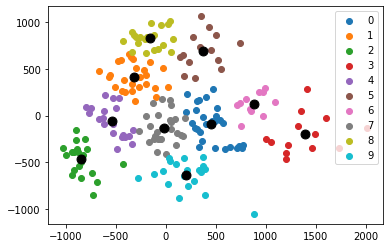

In [89]:
K = int(arr.shape[0]/200) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
threshold = 2 * np.sqrt(tr_splits[0].shape[1] - 1)
kmeans_1st_split = KM(tr_splits[0], num_clusters)

In [115]:
stats, cs_clusters, new_cs_clusters, rs_points = [], [], [], None
ds_clusters = summarise_info_clusters(kmeans_1st_split.labels_, tr_splits[0][:, 1:])
for chunk in range(1, K):
  unassigned_points = add_points_to_clusters(tr_splits[chunk][:, 1:], ds_clusters)
  if len(cs_clusters) > 0:
    if len(unassigned_points):
      unassigned_points = add_points_to_clusters(tr_splits[chunk][unassigned_points, 1:], cs_clusters)
  if len(unassigned_points) > 0:
    if chunk == 1:
      rs_points = tr_splits[chunk][unassigned_points, 1:]
    else:
      rs_points = np.append(rs_points, tr_splits[chunk][unassigned_points, 1:], axis=0)
  if len(rs_points) >= K:
    km = KMeans(K).fit(rs_points)
    rs_idx, cs_idx = process_cluster(group_cluster(km.labels_, rs_points))
    if len(cs_idx) > 0:
      if len(cs_clusters) > 0:
        new_cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      else:
        cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      if len(new_cs_clusters):
        cs_clusters = merge_clusters(cs_clusters, new_cs_clusters, threshold, return_two=False)
    if len(rs_idx) > 0:
      rs_points = rs_points[rs_idx]
  if chunk < (K - 1):
    stats.append(statistics(ds_clusters, cs_clusters, rs_points))

{'DS Clusters': 10, 'DS Points': 390, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 10, 'SUM': 400}
{'DS Clusters': 10, 'DS Points': 587, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 13, 'SUM': 600}
{'DS Clusters': 10, 'DS Points': 782, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 18, 'SUM': 800}
{'DS Clusters': 10, 'DS Points': 975, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 25, 'SUM': 1000}
{'DS Clusters': 10, 'DS Points': 1172, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 28, 'SUM': 1200}
{'DS Clusters': 10, 'DS Points': 1369, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 31, 'SUM': 1400}
{'DS Clusters': 10, 'DS Points': 1566, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 34, 'SUM': 1600}
{'DS Clusters': 10, 'DS Points': 1762, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 38, 'SUM': 1800}
{'DS Clusters': 10, 'DS Points': 1955, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 45, 'SUM': 2000}
{'DS Clusters': 10, 'DS Points': 2152, 'CS Clusters': 0, 'CS Points': 0, 'RS Poi

IndexError: ignored

In [116]:
ds_clusters, cs_clusters = merge_clusters(ds_clusters, cs_clusters, threshold, return_two=True)
stats.append(statistics(ds_clusters, cs_clusters, rs_points))
predictions = predict(K, ds_clusters, tr_splits, threshold)

{'DS Clusters': 10, 'DS Points': 17388, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 212, 'SUM': 17600}


## For K1=500

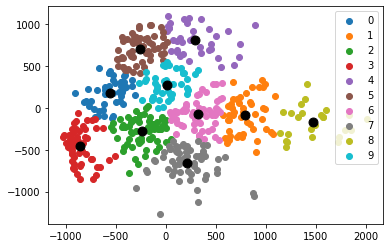

In [90]:
K = int(arr.shape[0]/500) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
threshold = 2 * np.sqrt(tr_splits[0].shape[1] - 1)
kmeans_1st_split = KM(tr_splits[0], num_clusters)

In [118]:
stats, cs_clusters, new_cs_clusters, rs_points = [], [], [], None
ds_clusters = summarise_info_clusters(kmeans_1st_split.labels_, tr_splits[0][:, 1:])
for chunk in range(1, K):
  unassigned_points = add_points_to_clusters(tr_splits[chunk][:, 1:], ds_clusters)
  if len(cs_clusters) > 0:
    if len(unassigned_points):
      unassigned_points = add_points_to_clusters(tr_splits[chunk][unassigned_points, 1:], cs_clusters)
  if len(unassigned_points) > 0:
    if chunk == 1:
      rs_points = tr_splits[chunk][unassigned_points, 1:]
    else:
      rs_points = np.append(rs_points, tr_splits[chunk][unassigned_points, 1:], axis=0)
  if len(rs_points) >= K:
    km = KMeans(K).fit(rs_points)
    rs_idx, cs_idx = process_cluster(group_cluster(km.labels_, rs_points))
    if len(cs_idx) > 0:
      if len(cs_clusters) > 0:
        new_cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      else:
        cs_clusters = summarise_info_clusters(km.labels_[tuple(cs_idx)], rs_points[tuple(cs_idx)])
      if len(new_cs_clusters):
        cs_clusters = merge_clusters(cs_clusters, new_cs_clusters, threshold, return_two=False)
    if len(rs_idx) > 0:
      rs_points = rs_points[rs_idx]
  if chunk < (K - 1):
    stats.append(statistics(ds_clusters, cs_clusters, rs_points))

{'DS Clusters': 10, 'DS Points': 990, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 10, 'SUM': 1000}
{'DS Clusters': 10, 'DS Points': 1484, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 16, 'SUM': 1500}
{'DS Clusters': 10, 'DS Points': 1975, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 25, 'SUM': 2000}
{'DS Clusters': 10, 'DS Points': 2471, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 29, 'SUM': 2500}
{'DS Clusters': 10, 'DS Points': 2956, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 44, 'SUM': 3000}
{'DS Clusters': 10, 'DS Points': 3447, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 53, 'SUM': 3500}
{'DS Clusters': 10, 'DS Points': 3941, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 59, 'SUM': 4000}
{'DS Clusters': 10, 'DS Points': 4434, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 66, 'SUM': 4500}
{'DS Clusters': 10, 'DS Points': 4930, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 70, 'SUM': 5000}
{'DS Clusters': 10, 'DS Points': 5425, 'CS Clusters': 0, 'CS Points': 0, '

IndexError: ignored

In [119]:
ds_clusters, cs_clusters = merge_clusters(ds_clusters, cs_clusters, threshold, return_two=True)
stats.append(statistics(ds_clusters, cs_clusters, rs_points))
predictions = predict(K, ds_clusters, tr_splits, threshold)

{'DS Clusters': 10, 'DS Points': 6914, 'CS Clusters': 0, 'CS Points': 0, 'RS Points': 86, 'SUM': 7000}


# Utility Function (Q2)

In [78]:
def cure(data, n_clusters, alpha, verbose=True):
    # Step 1: Initialize clusters with all data points
    clusters = [{i} for i in range(len(data))]
    num_clusters = len(clusters)
    if verbose:
        print(f"Initial number of clusters: {num_clusters}")

    # Step 2: Repeat until the number of clusters is less than or equal to n_clusters
    while num_clusters > n_clusters:
        # Step 3: Select the medoids
        num_medoids = max(int(alpha * len(data)), n_clusters)
        medoids = []
        for i in range(num_medoids):
            max_dist = -1
            medoid = None
            for c in clusters:
                if len(c) == 1:
                    dists = [0]
                else:
                    cluster_data = data[list(c)]
                    centroid = np.mean(cluster_data[:, 1:], axis=0)
                    dists = np.sum((cluster_data[:, 1:] - centroid)**2, axis=1)
                if max(dists) > max_dist:
                    max_dist = max(dists)
                    medoid = list(c)[np.argmax(dists)]
            medoids.append(medoid)

        # Step 4: Cluster the medoids using Agglomerative Clustering
        medoid_data = data[medoids][:, 1:]
        if not medoids:  # add this check
          continue
        agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
        agglomerative_clustering.fit(medoid_data)

        # Step 5: Merge the clusters whose medoids were grouped together in the Agglomerative Clustering
        new_clusters = [set() for i in range(n_clusters)]
        for i, c in enumerate(agglomerative_clustering.labels_):
            print("i:", i, "c:", c, "medoids[i]:", medoids[i])
            new_clusters[c].update(clusters[medoids[i]])
        clusters = [c for c in clusters if c not in [set(), set(medoids)]]
        clusters += new_clusters
        num_clusters = len(clusters)
        if verbose:
            print(f"Number of clusters after merging: {num_clusters}")

        # Step 6: Shrink the size of the clusters
        for i in range(len(clusters)):
            if len(clusters[i]) > 1:
                cluster = data[list(clusters[i])]
                centroid = np.mean(cluster[:, 1:], axis=0)
                distances = np.sqrt(np.sum((cluster[:, 1:] - centroid)**2, axis=1))
                sorted_indices = np.argsort(distances)
                num_points_to_keep = int(len(clusters[i]) * alpha)
                clusters[i] = set(np.array(list(clusters[i]))[sorted_indices][:num_points_to_keep])

    # Step 7: Assign final cluster labels
    cluster_labels = np.zeros(len(data), dtype=int)
    for i, c in enumerate(clusters):
        for j in c:
            cluster_labels[j] = i
    return cluster_labels

# Main Function (Q2)

## For K1=100

In [79]:
K = int(arr.shape[0]/100) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
cure(tr_splits[0], 10, 0.5, True)

Streaming output truncated to the last 5000 lines.
Number of clusters after merging: 125
i: 0 c: 0 medoids[i]: 5
i: 1 c: 0 medoids[i]: 5
i: 2 c: 0 medoids[i]: 5
i: 3 c: 0 medoids[i]: 5
i: 4 c: 0 medoids[i]: 5
i: 5 c: 0 medoids[i]: 5
i: 6 c: 0 medoids[i]: 5
i: 7 c: 0 medoids[i]: 5
i: 8 c: 0 medoids[i]: 5
i: 9 c: 0 medoids[i]: 5
i: 10 c: 0 medoids[i]: 5
i: 11 c: 0 medoids[i]: 5
i: 12 c: 0 medoids[i]: 5
i: 13 c: 0 medoids[i]: 5
i: 14 c: 0 medoids[i]: 5
i: 15 c: 0 medoids[i]: 5
i: 16 c: 0 medoids[i]: 5
i: 17 c: 0 medoids[i]: 5
i: 18 c: 0 medoids[i]: 5
i: 19 c: 0 medoids[i]: 5
i: 20 c: 0 medoids[i]: 5
i: 21 c: 0 medoids[i]: 5
i: 22 c: 0 medoids[i]: 5
i: 23 c: 0 medoids[i]: 5
i: 24 c: 0 medoids[i]: 5
i: 25 c: 0 medoids[i]: 5
i: 26 c: 0 medoids[i]: 5
i: 27 c: 0 medoids[i]: 5
i: 28 c: 0 medoids[i]: 5
i: 29 c: 0 medoids[i]: 5
i: 30 c: 0 medoids[i]: 5
i: 31 c: 0 medoids[i]: 5
i: 32 c: 0 medoids[i]: 5
i: 33 c: 0 medoids[i]: 5
i: 34 c: 0 medoids[i]: 5
i: 35 c: 0 medoids[i]: 5
i: 36 c: 0 medoids[i]

IndexError: ignored

## For K1=200

In [80]:
K = int(arr.shape[0]/200) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
cure(tr_splits[0], 10, 0.5, True)

Streaming output truncated to the last 5000 lines.
i: 51 c: 0 medoids[i]: 151
i: 52 c: 0 medoids[i]: 151
i: 53 c: 0 medoids[i]: 151
i: 54 c: 0 medoids[i]: 151
i: 55 c: 0 medoids[i]: 151
i: 56 c: 0 medoids[i]: 151
i: 57 c: 0 medoids[i]: 151
i: 58 c: 0 medoids[i]: 151
i: 59 c: 0 medoids[i]: 151
i: 60 c: 0 medoids[i]: 151
i: 61 c: 0 medoids[i]: 151
i: 62 c: 0 medoids[i]: 151
i: 63 c: 0 medoids[i]: 151
i: 64 c: 0 medoids[i]: 151
i: 65 c: 0 medoids[i]: 151
i: 66 c: 0 medoids[i]: 151
i: 67 c: 0 medoids[i]: 151
i: 68 c: 0 medoids[i]: 151
i: 69 c: 0 medoids[i]: 151
i: 70 c: 0 medoids[i]: 151
i: 71 c: 0 medoids[i]: 151
i: 72 c: 0 medoids[i]: 151
i: 73 c: 0 medoids[i]: 151
i: 74 c: 0 medoids[i]: 151
i: 75 c: 0 medoids[i]: 151
i: 76 c: 0 medoids[i]: 151
i: 77 c: 0 medoids[i]: 151
i: 78 c: 0 medoids[i]: 151
i: 79 c: 0 medoids[i]: 151
i: 80 c: 0 medoids[i]: 151
i: 81 c: 0 medoids[i]: 151
i: 82 c: 0 medoids[i]: 151
i: 83 c: 0 medoids[i]: 151
i: 84 c: 0 medoids[i]: 151
i: 85 c: 0 medoids[i]: 151
i: 8

IndexError: ignored

## For K1=500

In [91]:
K = int(arr.shape[0]/500) #here, K is chunks which is data/K1
tr_splits = np.array_split(tr_data, K)
cure(tr_splits[0], 10, 0.5, True)

Streaming output truncated to the last 5000 lines.
i: 21 c: 0 medoids[i]: 471
i: 22 c: 0 medoids[i]: 471
i: 23 c: 0 medoids[i]: 471
i: 24 c: 0 medoids[i]: 471
i: 25 c: 0 medoids[i]: 471
i: 26 c: 0 medoids[i]: 471
i: 27 c: 0 medoids[i]: 471
i: 28 c: 0 medoids[i]: 471
i: 29 c: 0 medoids[i]: 471
i: 30 c: 0 medoids[i]: 471
i: 31 c: 0 medoids[i]: 471
i: 32 c: 0 medoids[i]: 471
i: 33 c: 0 medoids[i]: 471
i: 34 c: 0 medoids[i]: 471
i: 35 c: 0 medoids[i]: 471
i: 36 c: 0 medoids[i]: 471
i: 37 c: 0 medoids[i]: 471
i: 38 c: 0 medoids[i]: 471
i: 39 c: 0 medoids[i]: 471
i: 40 c: 0 medoids[i]: 471
i: 41 c: 0 medoids[i]: 471
i: 42 c: 0 medoids[i]: 471
i: 43 c: 0 medoids[i]: 471
i: 44 c: 0 medoids[i]: 471
i: 45 c: 0 medoids[i]: 471
i: 46 c: 0 medoids[i]: 471
i: 47 c: 0 medoids[i]: 471
i: 48 c: 0 medoids[i]: 471
i: 49 c: 0 medoids[i]: 471
i: 50 c: 0 medoids[i]: 471
i: 51 c: 0 medoids[i]: 471
i: 52 c: 0 medoids[i]: 471
i: 53 c: 0 medoids[i]: 471
i: 54 c: 0 medoids[i]: 471
i: 55 c: 0 medoids[i]: 471
i: 5

IndexError: ignored